# This Jupyter Notebook shows how two-dimensional 21cm tomography samples can be generated with 21cmGAN.

We need to import some libraries and functionality from 21cmGAN:

In [1]:
import os
import tensorflow as tf
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from utils import get_default_dict, get_cmap21, PlotNormalise, undo_data_normalisation
from ops import scale_pars
from NN_21cm import NN_21cm

In [2]:
np.random.seed(0)

Load trained PGGAN
-----
First, we set the directory where the trained PGGAN is saved:

In [3]:
checkpt_dir_read = "/home/flo/PycharmProjects/21cm_new/checkpoints/HDF5_nonlin/6_False"

We need a dictionary with the hyperparameters that were used for training the PGGAN:

In [4]:
par = get_default_dict()

Let us now build the PGGAN:

In [5]:
model_21cm = NN_21cm(par, None, "", checkpt_dir_read, "", t=False, PG=par["fl_read"], only_eval=True)

Instructions for updating:
Colocations handled automatically by placer.


Now, we initialise the global variables and start a Tensorflow session:

In [6]:
init = tf.global_variables_initializer()
config = tf.ConfigProto(allow_soft_placement=True)
sess = tf.Session(config=config)
sess.run(init)

We define a saver and load the weights of the PGGAN:

In [7]:
saver = model_21cm.saver_eval
saver.restore(sess, tf.train.latest_checkpoint(model_21cm.checkpt_dir_read))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /home/flo/PycharmProjects/21cm_new/checkpoints/HDF5_nonlin/6_False/trained.ckpt-440000


Let's define some sets of parameters $\theta = (f_X, r_{h/s}, f_\alpha)$, where $f_X$ is the X-ray emissivity $(0.1 - 10.0)$, $r_{h/s}$ is the fraction of hard X-rays $(0.0 - 1.0)$, and $f_\alpha$ is the Lyman-band emissivity $(0.5 - 2.0)$. The values denote the range on which 21cmGAN has been trained (see B. Semelin, E. Eames, F. Bolgar, M. Caillat, 21SSD: a public data base of simulated 21-cm signals from the epoch of reionization, 2017, MNRAS 472, 4508, https://doi.org/10.1093/mnras/stx2274 for more details on the 21SSD catalogue that was used for training).

Choose parameters and random noise
-----

In [8]:
theta = np.asarray([[10, 0, 2], [1, 0.5, 1], [0.1, 1, 2]])

21cmGAN expects the parameter to be rescaled, that is with the mean over each parameter removed, and divided by the standard deviation:

In [9]:
theta_feed = scale_pars(theta, mean=par["X_mean"], std=par["X_std"])[0]
print(theta_feed)

[[ 1.42697648 -1.22474487  1.22474488]
 [ 0.01294055  0.          0.        ]
 [-1.40109539  1.22474487  1.22474488]]


First, let us create samples for all parameter vectors using different noise vectors:

In [10]:
noise = np.random.normal(0, 1, [theta.shape[0], par["n_noise"]])

Sample creation
-----
Generate samples for all parameter vectors with 21cmGAN:

In [11]:
samples = np.squeeze(model_21cm.sample_generator(sess, theta_feed, noise, is_training=False), -1)

Let us have a look at the output of the neural network:

In [12]:
print(samples.shape)
print(samples.min())
print(samples.max())
print(np.quantile(samples, [0.01, 0.99]))

(3, 32, 256)
-1.6201606
1.2843301
[-0.93299755  0.83718002]


We have generated 3 samples of resolution 32 x 256 (one for each parameter vector), and >98% of the pixel values lie between -1 and 1. 

In order to obtain temperature values at each pixel, we need to undo the transformation that was applied to the training data before training 21cmGAN:

In [13]:
samples = undo_data_normalisation(par, samples)

In [14]:
print(samples.min())
print(samples.max())

-279.59052803036155
94.988300538842


Now, the pixel values correspond to the brightness temperature in mK.

Next, let us plot the samples using the same colourmap and colourmap normalisation that was used in the 21cmGAN paper:

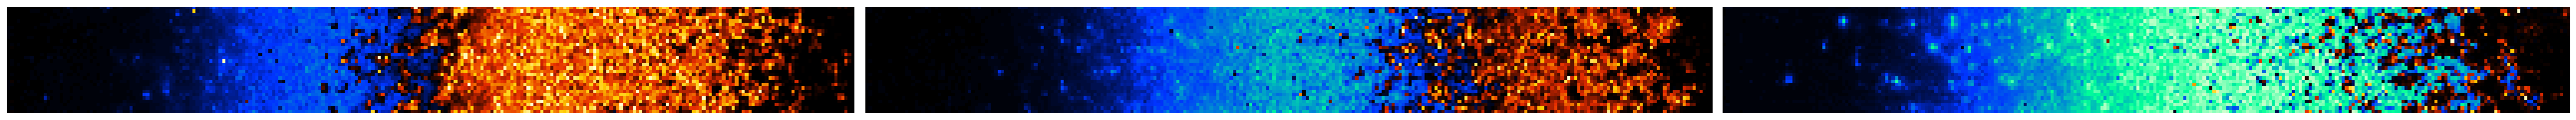

In [15]:
fig, axs = plt.subplots(1, theta.shape[0], figsize=(36, 6))
for i_ax, ax in enumerate(axs):    
    ax.imshow(samples[i_ax], cmap=get_cmap21(), norm=PlotNormalise(par))
    ax.axis("off")
plt.tight_layout()

The left / right edge of the tomography samples corresponds to a redshift of $z = 15$ / $z = 6$, and the horizontal axis has a constant spacing w.r.t. $a = (1+z)^{-1}$.

Let's plot the vertically averaged brightness temperature as a function of redshift:

/home/flo/.local/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


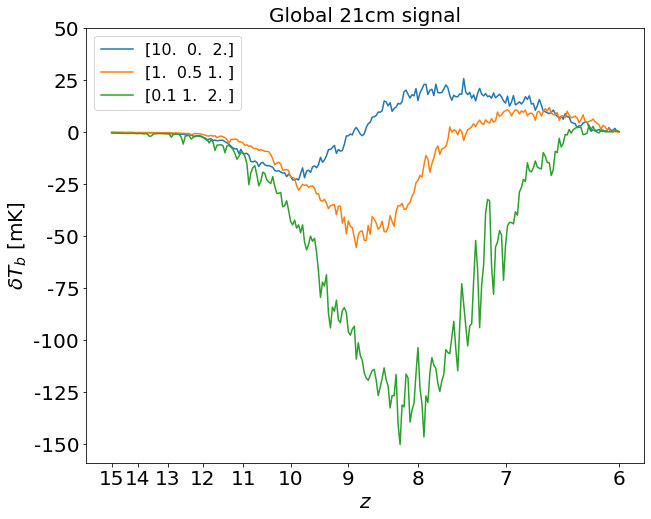

In [16]:
fig_avg, ax_avg = plt.subplots(1, 1, figsize=(10, 8))
labels_nu = np.arange(6, 16)[::-1]
labels_pos = np.cumsum(np.asarray([1 / z - 1 / (z + 1) for z in labels_nu[:-1]]))
labels_pos *= (samples.shape[-1] - 1) / labels_pos[-1]
labels_pos = np.hstack([0, labels_pos])
for i_plot in range(theta.shape[0]):
    ax_avg.plot(samples[i_plot].mean(0))
ax_avg.set_title("Global 21cm signal", fontsize=20)
ax_avg.set_yticks(np.arange(-150, 75, 25))
ax_avg.set_yticklabels(np.arange(-150, 75, 25), fontsize=20)
ax_avg.set_ylabel("$\delta T_b$ [mK]", fontsize=20)
ax_avg.set_xticks(labels_pos)
ax_avg.set_xticklabels(labels_nu, fontsize=20)
ax_avg.set_xlabel(r"$z$", fontsize=20)
ax_avg.legend(theta, fontsize=16)
plt.show()

Interpolating in parameter space
-----
Next, let us consider how these samples change as we gradually vary the parameters, keeping the noise vector fixed. For the first sample, we will gradually decrease $f_X$, for the second sample, we will increase $f_\alpha$, and for the third sample, we will decrease $r_{h/s}$.

In [17]:
theta_new = scale_pars(np.repeat(theta, 5, axis=0), mean=par["X_mean"], std=par["X_std"])[0]
theta_new[:5, 0] -= np.linspace(0, 1, 5)
theta_new[5:10, 2] += np.linspace(0, 1.2, 5)
theta_new[10:15, 2] -= np.linspace(0, 2.4, 5)

In [18]:
noise_new = np.repeat(noise, 5, axis=0)

Let's get the samples from 21cmGAN (this takes a moment because of the calculation of the inverse function when undoing the data normalisation...):

In [19]:
samples_new = undo_data_normalisation(par, np.squeeze(model_21cm.sample_generator(sess, theta_new, noise_new, is_training=False), -1))

Let's make a plot of the generated samples:

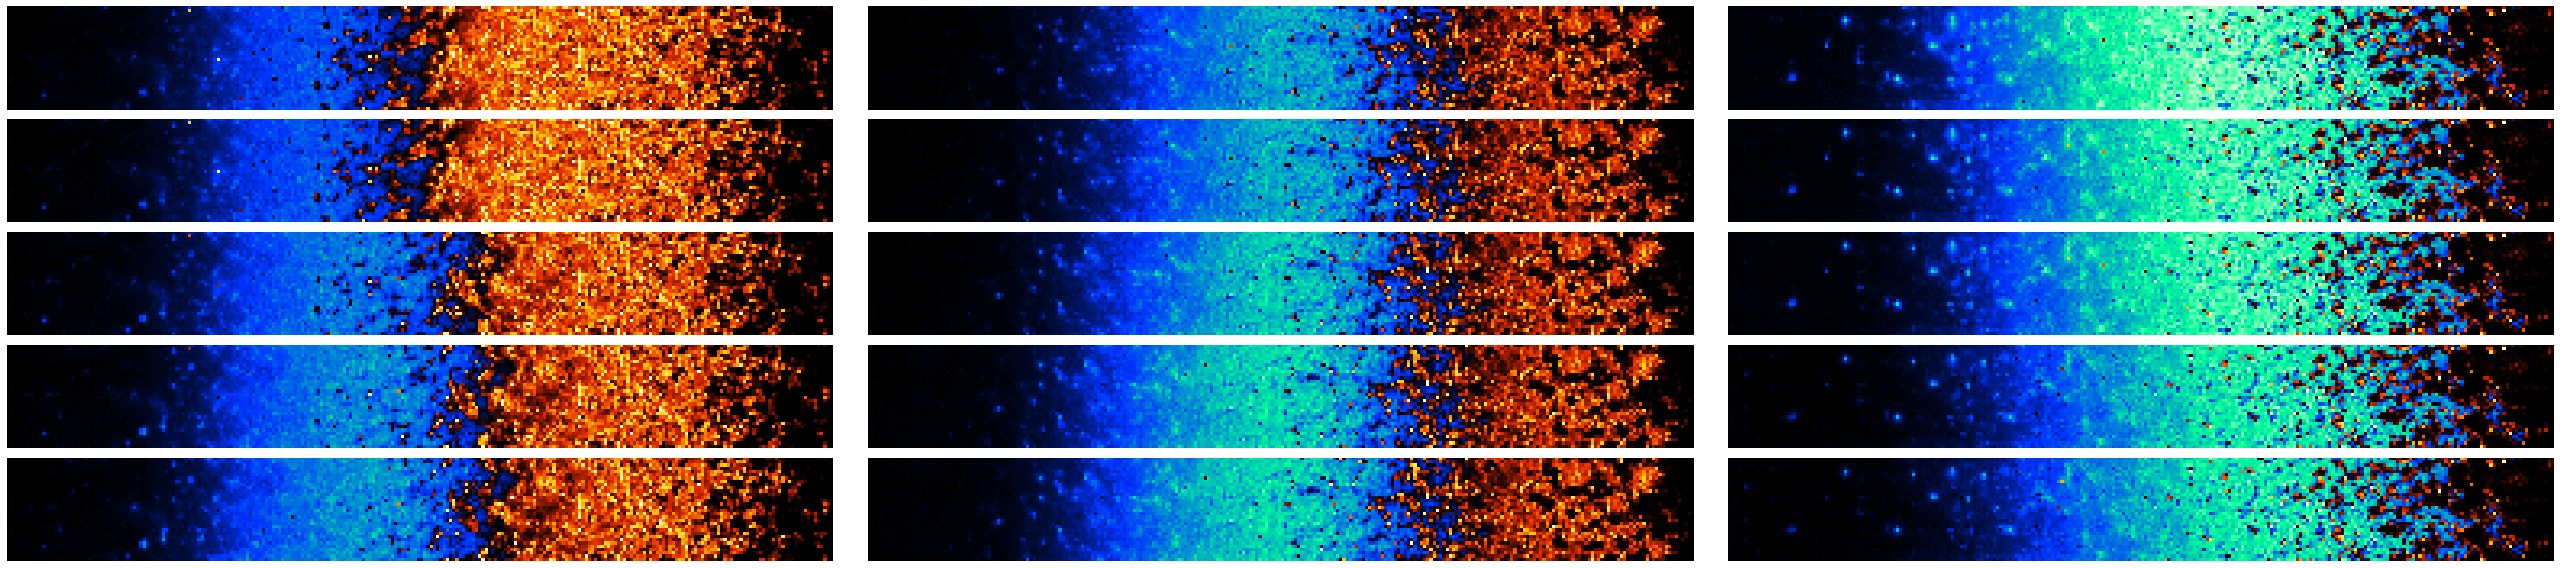

In [20]:
fig_new, axs_new = plt.subplots(5, theta.shape[0], figsize=(36, 8))
for i_ax in range(5 * theta.shape[0]):      
    ax_inds = np.unravel_index(i_ax, [5, theta.shape[0]], "F")
    axs_new[ax_inds].imshow(samples_new[i_ax], cmap=get_cmap21(), norm=PlotNormalise(par))
    axs_new[ax_inds].axis("off")
plt.tight_layout()

Note the similarity of the spatial fluctuations within each column due to the fixed noise vector. In the first column, the decreasing X-ray efficiency $f_X$ (from top to bottom) leads to a growing absorption region and shrinking emission region. In the second column, the increasing Lyman-band emissivity $f_\alpha$ increases the amplitude of the absorption trough. The impact on the decreasing X-ray hard-to-soft ratio in the third column is small, but one can notice how absorption islands at high redshift disappear and the 21cm absorption signal becomes visible slightly later.